# LightGBM
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "abomination-vaults-bestiary.db",
    "age-of-ashes-bestiary.db",
    "agents-of-edgewatch-bestiary.db",
    "april-fools-bestiary.db",
    "blog-bestiary.db",
    "blood-lords-bestiary.db",
    "book-of-the-dead-bestiary.db",
    "crown-of-the-kobold-king-bestiary.db",
    "extinction-curse-bestiary.db",
    "fall-of-plaguestone.db",
    "fists-of-the-ruby-phoenix-bestiary.db",
    "gatewalkers-bestiary.db",
    "impossible-lands-bestiary.db",
    "kingmaker-bestiary.db",
    "malevolence-bestiary.db",
    "menace-under-otari-bestiary.db",
    "monsters-of-myth-bestiary.db",
    "mwangi-expanse-bestiary.db",
    "night-of-the-gray-death-bestiary.db",
    "npc-gallery.db",
    "one-shot-bestiary.db",
    "outlaws-of-alkenstar-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
    "pathfinder-bestiary.db",
    "pathfinder-dark-archive.db",
    "pfs-introductions-bestiary.db",
    "pfs-season-1-bestiary.db",
    "pfs-season-2-bestiary.db",
    "pfs-season-3-bestiary.db",
    "pfs-season-4-bestiary.db",
    "quest-for-the-frozen-flame-bestiary.db",
    "shadows-at-sundown-bestiary.db",
    "strength-of-thousands-bestiary.db",
    "the-slithering-bestiary.db",
    "travel-guide-bestiary.db",
    "troubles-in-otari-bestiary.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3690 entries, 0 to 4327
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   con                     3690 non-null   float64
 1   perception              3690 non-null   float64
 2   ac                      3690 non-null   float64
 3   cha                     3690 non-null   float64
 4   focus                   3690 non-null   int32  
 5   will                    3690 non-null   float64
 6   fortitude               3690 non-null   float64
 7   land_speed              3690 non-null   float64
 8   level                   3690 non-null   int64  
 9   hp                      3690 non-null   int32  
 10  wis                     3690 non-null   float64
 11  reflex                  3690 non-null   float64
 12  int                     3690 non-null   float64
 13  num_immunities          3690 non-null   int64  
 14  dex                     3690 non-null   

In [3]:
df.head()

,con,perception,ac,cha,focus,will,fortitude,land_speed,level,hp,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,0.0,18.0,28.0,0.0,1,20.0,15.0,20.0,9,155,...,2,0,0,0,0,0,21,19.0,0,0.0
1,6.0,19.0,30.0,0.0,0,19.0,22.0,40.0,10,175,...,0,0,0,0,0,0,23,22.0,0,0.0
2,1.0,7.0,17.0,1.0,0,9.0,7.0,30.0,2,38,...,0,0,0,0,0,0,9,6.5,8,6.5
3,3.0,16.0,27.0,1.0,0,15.0,17.0,30.0,8,140,...,0,0,0,0,0,0,20,18.0,20,9.5
4,0.0,20.0,31.0,2.0,0,18.0,14.0,0.0,9,90,...,0,0,0,0,0,0,17,21.5,0,0.0


###### Level

In [4]:
y = df["level"]
y

0        9
1       10
2        2
3        8
4        9
        ..
4322     2
4324     3
4325     4
4326     2
4327     2
Name: level, Length: 3690, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,147
1,0,87
2,1,320
3,2,335
4,3,339
5,4,274
6,5,268
7,6,220
8,7,215
9,8,188


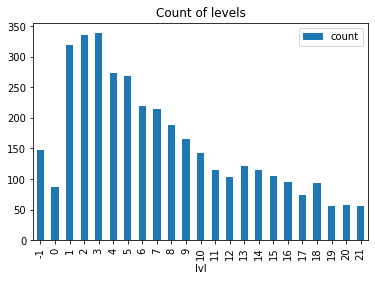

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")

plt.savefig(f"../results_diagrams/other/Count of levels.svg")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 1626, number of used features: 50
[LightGBM] [Info] Start training from score 7.212177
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.356037	valid_0's l2: 0.355836


In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.60
MAE: 0.36


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "full", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.17
RMSE test: 0.60


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

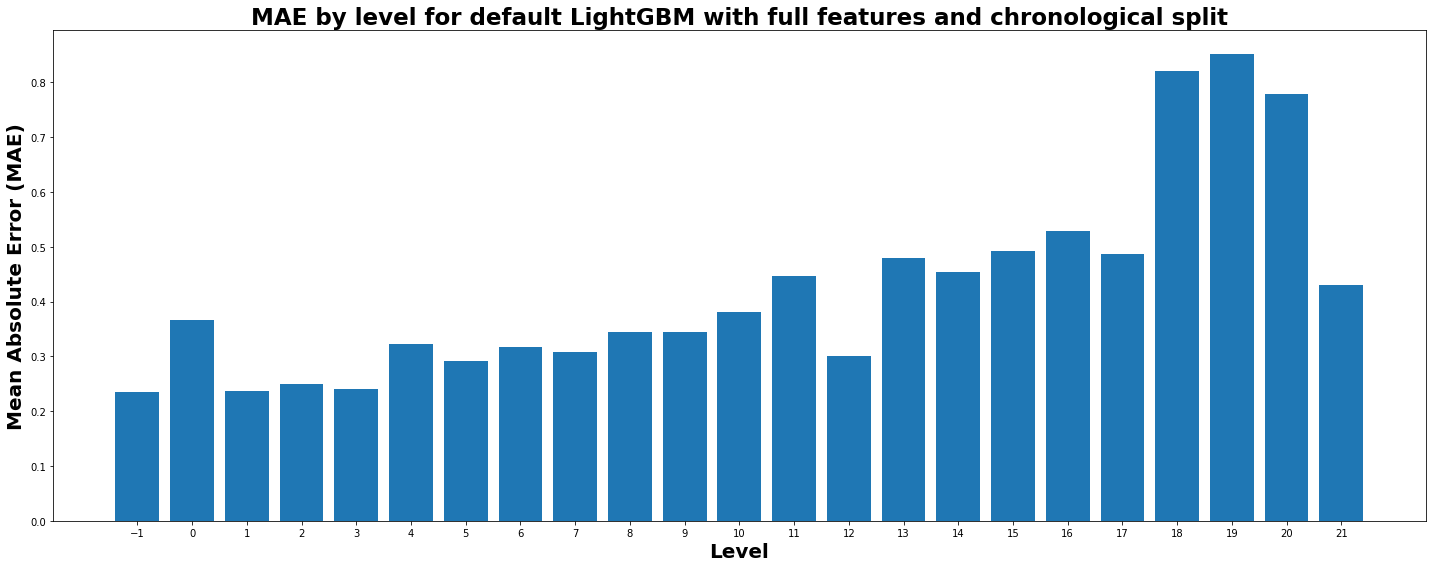

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and chronological split",
)

In [19]:
from training.results import evaluate_round_predictions, plot_confusion_matrix


evaluate_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.60

Round type: 0.5
RMSE: 0.62

Round type: 0.33
RMSE: 0.64

Round type: 0.45
RMSE: 0.62



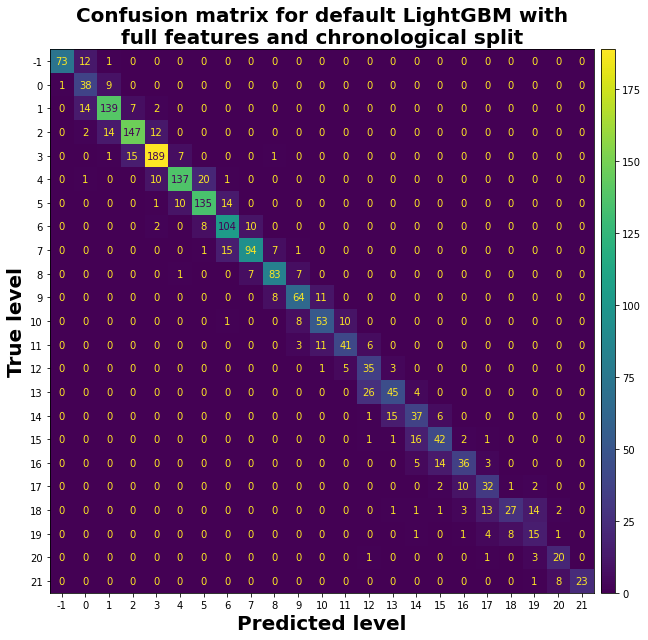

In [20]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with\nfull features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-12-01 17:43:15,140] A new study created in memory with name: no-name-aa016101-6e25-4093-8c5e-4ced397c2b12
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.178373 + 0.112111
[200]	cv_agg's l2: 0.176605 + 0.108465


feature_fraction, val_score: 0.176345:  14%|######4                                      | 1/7 [00:06<00:40,  6.70s/it]

Early stopping, best iteration is:
[174]	cv_agg's l2: 0.176345 + 0.108236
[100]	cv_agg's l2: 0.17668 + 0.102699
[200]	cv_agg's l2: 0.173587 + 0.100624


feature_fraction, val_score: 0.173475:  29%|############8                                | 2/7 [00:11<00:27,  5.55s/it]

Early stopping, best iteration is:
[168]	cv_agg's l2: 0.173475 + 0.100786
[100]	cv_agg's l2: 0.17272 + 0.11437
[200]	cv_agg's l2: 0.168877 + 0.111125
[300]	cv_agg's l2: 0.168049 + 0.11026
[400]	cv_agg's l2: 0.168014 + 0.109485


feature_fraction, val_score: 0.167905:  43%|###################2                         | 3/7 [00:17<00:22,  5.70s/it]

Early stopping, best iteration is:
[336]	cv_agg's l2: 0.167905 + 0.10979
[100]	cv_agg's l2: 0.179626 + 0.11688
[200]	cv_agg's l2: 0.17528 + 0.114249
[300]	cv_agg's l2: 0.174793 + 0.113212
[400]	cv_agg's l2: 0.175066 + 0.112771


feature_fraction, val_score: 0.167905:  57%|#########################7                   | 4/7 [00:24<00:19,  6.48s/it]

Early stopping, best iteration is:
[336]	cv_agg's l2: 0.167905 + 0.10979
[100]	cv_agg's l2: 0.188137 + 0.130897
[200]	cv_agg's l2: 0.183959 + 0.126495
[300]	cv_agg's l2: 0.183887 + 0.126002
[400]	cv_agg's l2: 0.184082 + 0.125316


feature_fraction, val_score: 0.167905:  71%|################################1            | 5/7 [00:30<00:12,  6.10s/it]

Early stopping, best iteration is:
[336]	cv_agg's l2: 0.167905 + 0.10979
[100]	cv_agg's l2: 0.181278 + 0.124894
[200]	cv_agg's l2: 0.177467 + 0.119141
[300]	cv_agg's l2: 0.177587 + 0.117786
[400]	cv_agg's l2: 0.177824 + 0.11696


feature_fraction, val_score: 0.167905:  86%|######################################5      | 6/7 [00:36<00:06,  6.02s/it]

Early stopping, best iteration is:
[336]	cv_agg's l2: 0.167905 + 0.10979
[100]	cv_agg's l2: 0.173534 + 0.103085
[200]	cv_agg's l2: 0.171859 + 0.101362
[300]	cv_agg's l2: 0.172861 + 0.10068
[400]	cv_agg's l2: 0.173998 + 0.100421


feature_fraction, val_score: 0.167905: 100%|#############################################| 7/7 [00:42<00:00,  6.02s/it]


Early stopping, best iteration is:
[336]	cv_agg's l2: 0.167905 + 0.10979


num_leaves, val_score: 0.167905:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.172525 + 0.112101
[200]	cv_agg's l2: 0.164747 + 0.106125
[300]	cv_agg's l2: 0.163652 + 0.10375


num_leaves, val_score: 0.163290:   5%|##5                                               | 1/20 [00:02<00:49,  2.60s/it]

[400]	cv_agg's l2: 0.163952 + 0.102503
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178302 + 0.120096
[200]	cv_agg's l2: 0.17444 + 0.114093
[300]	cv_agg's l2: 0.174416 + 0.113084
[400]	cv_agg's l2: 0.174159 + 0.112315


num_leaves, val_score: 0.163290:  10%|#####                                             | 2/20 [00:10<01:44,  5.78s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.276752 + 0.131179
[200]	cv_agg's l2: 0.238139 + 0.11575
[300]	cv_agg's l2: 0.220363 + 0.107341


num_leaves, val_score: 0.163290:  15%|#######5                                          | 3/20 [00:11<01:00,  3.56s/it]

[400]	cv_agg's l2: 0.208125 + 0.10197
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178302 + 0.120096
[200]	cv_agg's l2: 0.17444 + 0.114093
[300]	cv_agg's l2: 0.174416 + 0.113084
[400]	cv_agg's l2: 0.174159 + 0.112315


num_leaves, val_score: 0.163290:  20%|##########                                        | 4/20 [00:20<01:31,  5.69s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178302 + 0.120096
[200]	cv_agg's l2: 0.17444 + 0.114093
[300]	cv_agg's l2: 0.174416 + 0.113084
[400]	cv_agg's l2: 0.174159 + 0.112315


num_leaves, val_score: 0.163290:  25%|############5                                     | 5/20 [00:29<01:45,  7.02s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.276752 + 0.131179
[200]	cv_agg's l2: 0.238139 + 0.11575
[300]	cv_agg's l2: 0.220363 + 0.107341


num_leaves, val_score: 0.163290:  30%|###############                                   | 6/20 [00:30<01:09,  4.98s/it]

[400]	cv_agg's l2: 0.208125 + 0.10197
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178302 + 0.120096
[200]	cv_agg's l2: 0.17444 + 0.114093
[300]	cv_agg's l2: 0.174416 + 0.113084
[400]	cv_agg's l2: 0.174159 + 0.112315


num_leaves, val_score: 0.163290:  35%|#################5                                | 7/20 [00:41<01:28,  6.81s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178302 + 0.120096
[200]	cv_agg's l2: 0.17444 + 0.114093
[300]	cv_agg's l2: 0.174416 + 0.113084
[400]	cv_agg's l2: 0.174159 + 0.112315


num_leaves, val_score: 0.163290:  40%|####################                              | 8/20 [00:49<01:27,  7.28s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178302 + 0.120096
[200]	cv_agg's l2: 0.17444 + 0.114093
[300]	cv_agg's l2: 0.174416 + 0.113084
[400]	cv_agg's l2: 0.174159 + 0.112315


num_leaves, val_score: 0.163290:  45%|######################5                           | 9/20 [00:58<01:24,  7.69s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178302 + 0.120096
[200]	cv_agg's l2: 0.17444 + 0.114093
[300]	cv_agg's l2: 0.174416 + 0.113084
[400]	cv_agg's l2: 0.174159 + 0.112315


num_leaves, val_score: 0.163290:  50%|########################5                        | 10/20 [01:06<01:19,  7.94s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178302 + 0.120096
[200]	cv_agg's l2: 0.17444 + 0.114093
[300]	cv_agg's l2: 0.174416 + 0.113084
[400]	cv_agg's l2: 0.174159 + 0.112315


num_leaves, val_score: 0.163290:  55%|##########################9                      | 11/20 [01:15<01:13,  8.20s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178302 + 0.120096
[200]	cv_agg's l2: 0.17444 + 0.114093
[300]	cv_agg's l2: 0.174416 + 0.113084
[400]	cv_agg's l2: 0.174159 + 0.112315


num_leaves, val_score: 0.163290:  60%|#############################4                   | 12/20 [01:24<01:08,  8.52s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.174358 + 0.115088
[200]	cv_agg's l2: 0.171011 + 0.110667
[300]	cv_agg's l2: 0.170871 + 0.108989
[400]	cv_agg's l2: 0.17115 + 0.108387


num_leaves, val_score: 0.163290:  65%|###############################8                 | 13/20 [01:32<00:57,  8.16s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178302 + 0.120096
[200]	cv_agg's l2: 0.17444 + 0.114093
[300]	cv_agg's l2: 0.174416 + 0.113084
[400]	cv_agg's l2: 0.174159 + 0.112315


num_leaves, val_score: 0.163290:  70%|##################################3              | 14/20 [01:40<00:49,  8.32s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.17414 + 0.115714
[200]	cv_agg's l2: 0.170962 + 0.11237
[300]	cv_agg's l2: 0.170712 + 0.111491
[400]	cv_agg's l2: 0.171016 + 0.11082


num_leaves, val_score: 0.163290:  75%|####################################7            | 15/20 [01:46<00:37,  7.49s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.17414 + 0.115714
[200]	cv_agg's l2: 0.170962 + 0.11237
[300]	cv_agg's l2: 0.170712 + 0.111491
[400]	cv_agg's l2: 0.171016 + 0.11082


num_leaves, val_score: 0.163290:  80%|#######################################2         | 16/20 [01:52<00:27,  6.90s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178302 + 0.120096
[200]	cv_agg's l2: 0.17444 + 0.114093
[300]	cv_agg's l2: 0.174416 + 0.113084
[400]	cv_agg's l2: 0.174159 + 0.112315


num_leaves, val_score: 0.163290:  85%|#########################################6       | 17/20 [02:00<00:21,  7.28s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.17414 + 0.115714
[200]	cv_agg's l2: 0.170962 + 0.11237
[300]	cv_agg's l2: 0.170712 + 0.111491
[400]	cv_agg's l2: 0.171016 + 0.11082


num_leaves, val_score: 0.163290:  90%|############################################1    | 18/20 [02:05<00:13,  6.73s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178302 + 0.120096
[200]	cv_agg's l2: 0.17444 + 0.114093
[300]	cv_agg's l2: 0.174416 + 0.113084
[400]	cv_agg's l2: 0.174159 + 0.112315


num_leaves, val_score: 0.163290:  95%|##############################################5  | 19/20 [02:14<00:07,  7.40s/it]

Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.178933 + 0.121803
[200]	cv_agg's l2: 0.175984 + 0.118076
[300]	cv_agg's l2: 0.176459 + 0.116851
[400]	cv_agg's l2: 0.176505 + 0.115983


num_leaves, val_score: 0.163290: 100%|#################################################| 20/20 [02:22<00:00,  7.11s/it]


Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646


bagging, val_score: 0.163290:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.194717 + 0.128284
[200]	cv_agg's l2: 0.183912 + 0.114737
[300]	cv_agg's l2: 0.184036 + 0.110874


bagging, val_score: 0.163290:  10%|#####3                                               | 1/10 [00:02<00:25,  2.84s/it]

[400]	cv_agg's l2: 0.183742 + 0.108728
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.175574 + 0.11509
[200]	cv_agg's l2: 0.168362 + 0.108006
[300]	cv_agg's l2: 0.167543 + 0.106191


bagging, val_score: 0.163290:  20%|##########6                                          | 2/10 [00:05<00:23,  2.88s/it]

[400]	cv_agg's l2: 0.168213 + 0.106491
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.1734 + 0.110546
[200]	cv_agg's l2: 0.167334 + 0.106977
[300]	cv_agg's l2: 0.165861 + 0.105256


bagging, val_score: 0.163290:  30%|###############9                                     | 3/10 [00:08<00:19,  2.78s/it]

[400]	cv_agg's l2: 0.166325 + 0.104191
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.171192 + 0.110181
[200]	cv_agg's l2: 0.164266 + 0.101745
[300]	cv_agg's l2: 0.164104 + 0.0999867


bagging, val_score: 0.163290:  40%|#####################2                               | 4/10 [00:11<00:16,  2.74s/it]

[400]	cv_agg's l2: 0.164158 + 0.0996616
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.173453 + 0.112436
[200]	cv_agg's l2: 0.167047 + 0.108261
[300]	cv_agg's l2: 0.166422 + 0.106789


bagging, val_score: 0.163290:  50%|##########################5                          | 5/10 [00:14<00:14,  2.86s/it]

[400]	cv_agg's l2: 0.166958 + 0.106614
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.171079 + 0.109679
[200]	cv_agg's l2: 0.165265 + 0.105351
[300]	cv_agg's l2: 0.164753 + 0.105054


bagging, val_score: 0.163290:  60%|###############################8                     | 6/10 [00:17<00:11,  2.87s/it]

[400]	cv_agg's l2: 0.164982 + 0.10418
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.175655 + 0.115393
[200]	cv_agg's l2: 0.169152 + 0.110708
[300]	cv_agg's l2: 0.167813 + 0.108697


bagging, val_score: 0.163290:  70%|#####################################                | 7/10 [00:19<00:08,  2.79s/it]

[400]	cv_agg's l2: 0.169255 + 0.108395
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.176824 + 0.105622
[200]	cv_agg's l2: 0.168351 + 0.098109
[300]	cv_agg's l2: 0.168383 + 0.0964879


bagging, val_score: 0.163290:  80%|##########################################4          | 8/10 [00:22<00:05,  2.81s/it]

[400]	cv_agg's l2: 0.170379 + 0.0954391
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.174534 + 0.106999
[200]	cv_agg's l2: 0.166711 + 0.0990536
[300]	cv_agg's l2: 0.16674 + 0.0972528


bagging, val_score: 0.163290:  90%|###############################################7     | 9/10 [00:25<00:02,  2.90s/it]

[400]	cv_agg's l2: 0.168309 + 0.0957289
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.174091 + 0.115438
[200]	cv_agg's l2: 0.165259 + 0.107283
[300]	cv_agg's l2: 0.165309 + 0.103835


bagging, val_score: 0.163290: 100%|####################################################| 10/10 [00:28<00:00,  2.87s/it]


[400]	cv_agg's l2: 0.165906 + 0.102489
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646


feature_fraction_stage2, val_score: 0.163290:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.17378 + 0.106051
[200]	cv_agg's l2: 0.164721 + 0.0998499
[300]	cv_agg's l2: 0.163618 + 0.0974935


feature_fraction_stage2, val_score: 0.163290:  17%|######3                               | 1/6 [00:02<00:14,  2.81s/it]

[400]	cv_agg's l2: 0.164214 + 0.0957176
Early stopping, best iteration is:
[321]	cv_agg's l2: 0.16329 + 0.103646
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


feature_fraction_stage2, val_score: 0.162586:  33%|############6                         | 2/6 [00:05<00:11,  2.87s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.175146 + 0.11006
[200]	cv_agg's l2: 0.165591 + 0.103546
[300]	cv_agg's l2: 0.163887 + 0.102871


feature_fraction_stage2, val_score: 0.162586:  50%|###################                   | 3/6 [00:12<00:13,  4.52s/it]

[400]	cv_agg's l2: 0.165011 + 0.102194
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.172873 + 0.109543
[200]	cv_agg's l2: 0.165875 + 0.104184
[300]	cv_agg's l2: 0.165506 + 0.101894


feature_fraction_stage2, val_score: 0.162586:  67%|#########################3            | 4/6 [00:14<00:06,  3.47s/it]

[400]	cv_agg's l2: 0.165725 + 0.101445
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.175636 + 0.118153
[200]	cv_agg's l2: 0.166406 + 0.111355
[300]	cv_agg's l2: 0.164518 + 0.110037


feature_fraction_stage2, val_score: 0.162586:  83%|###############################6      | 5/6 [00:15<00:02,  2.83s/it]

[400]	cv_agg's l2: 0.164808 + 0.109364
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.173926 + 0.11419
[200]	cv_agg's l2: 0.165398 + 0.108346
[300]	cv_agg's l2: 0.163578 + 0.108018


feature_fraction_stage2, val_score: 0.162586: 100%|######################################| 6/6 [00:17<00:00,  2.92s/it]


[400]	cv_agg's l2: 0.163062 + 0.107326
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625


regularization_factors, val_score: 0.162586:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.178051 + 0.106196
[200]	cv_agg's l2: 0.167851 + 0.0992368
[300]	cv_agg's l2: 0.165539 + 0.0967895


regularization_factors, val_score: 0.162586:   5%|#9                                    | 1/20 [00:01<00:30,  1.61s/it]

[400]	cv_agg's l2: 0.165935 + 0.0955478
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  10%|###8                                  | 2/20 [00:03<00:28,  1.57s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  15%|#####7                                | 3/20 [00:04<00:26,  1.56s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  20%|#######6                              | 4/20 [00:06<00:24,  1.54s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  25%|#########5                            | 5/20 [00:07<00:22,  1.53s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  30%|###########4                          | 6/20 [00:09<00:21,  1.54s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  35%|#############3                        | 7/20 [00:11<00:20,  1.60s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  40%|###############2                      | 8/20 [00:12<00:18,  1.57s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  45%|#################1                    | 9/20 [00:14<00:17,  1.62s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  50%|##################5                  | 10/20 [00:15<00:16,  1.63s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  55%|####################3                | 11/20 [00:17<00:14,  1.62s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  60%|######################2              | 12/20 [00:19<00:13,  1.70s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  65%|########################             | 13/20 [00:21<00:11,  1.70s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.175249 + 0.103395
[200]	cv_agg's l2: 0.165278 + 0.0982046
[300]	cv_agg's l2: 0.163752 + 0.0951842


regularization_factors, val_score: 0.162586:  70%|#########################9           | 14/20 [00:22<00:10,  1.68s/it]

[400]	cv_agg's l2: 0.163575 + 0.0950442
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.175249 + 0.103395
[200]	cv_agg's l2: 0.165278 + 0.0982046
[300]	cv_agg's l2: 0.163752 + 0.0951842


regularization_factors, val_score: 0.162586:  75%|###########################7         | 15/20 [00:24<00:08,  1.73s/it]

[400]	cv_agg's l2: 0.163575 + 0.0950442
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  80%|#############################6       | 16/20 [00:26<00:06,  1.69s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.175249 + 0.103395
[200]	cv_agg's l2: 0.165278 + 0.0982046
[300]	cv_agg's l2: 0.163752 + 0.0951842


regularization_factors, val_score: 0.162586:  85%|###############################4     | 17/20 [00:27<00:05,  1.69s/it]

[400]	cv_agg's l2: 0.163575 + 0.0950442
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  90%|#################################3   | 18/20 [00:29<00:03,  1.65s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586:  95%|###################################1 | 19/20 [00:31<00:01,  1.65s/it]

[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.174366 + 0.104081
[200]	cv_agg's l2: 0.164673 + 0.0986944
[300]	cv_agg's l2: 0.163153 + 0.0956797


regularization_factors, val_score: 0.162586: 100%|#####################################| 20/20 [00:32<00:00,  1.64s/it]


[400]	cv_agg's l2: 0.163083 + 0.0954548
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625


min_data_in_leaf, val_score: 0.162586:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.174394 + 0.113755
[200]	cv_agg's l2: 0.16771 + 0.11082
[300]	cv_agg's l2: 0.167002 + 0.108581


min_data_in_leaf, val_score: 0.162586:  20%|#########                                    | 1/5 [00:01<00:06,  1.67s/it]

[400]	cv_agg's l2: 0.166774 + 0.107433
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.206082 + 0.11497
[200]	cv_agg's l2: 0.192218 + 0.10641
[300]	cv_agg's l2: 0.187697 + 0.102907


min_data_in_leaf, val_score: 0.162586:  40%|##################                           | 2/5 [00:03<00:04,  1.65s/it]

[400]	cv_agg's l2: 0.186234 + 0.100947
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.178466 + 0.108278
[200]	cv_agg's l2: 0.171166 + 0.104391
[300]	cv_agg's l2: 0.16916 + 0.10373


min_data_in_leaf, val_score: 0.162586:  60%|###########################                  | 3/5 [00:04<00:03,  1.65s/it]

[400]	cv_agg's l2: 0.169022 + 0.101912
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.178945 + 0.114431
[200]	cv_agg's l2: 0.171638 + 0.109648
[300]	cv_agg's l2: 0.170697 + 0.108743


min_data_in_leaf, val_score: 0.162586:  80%|####################################         | 4/5 [00:06<00:01,  1.68s/it]

[400]	cv_agg's l2: 0.170127 + 0.108902
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625
[100]	cv_agg's l2: 0.308203 + 0.153291
[200]	cv_agg's l2: 0.287403 + 0.148715
[300]	cv_agg's l2: 0.278131 + 0.145916


min_data_in_leaf, val_score: 0.162586: 100%|#############################################| 5/5 [00:07<00:00,  1.58s/it]

[400]	cv_agg's l2: 0.275034 + 0.144545
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.162586 + 0.0954625


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1625864649179006
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 5.5165771369e-07
    lambda_l2: 8.499918958328592e-07
    num_leaves: 14
    feature_fraction: 0.652
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.55
MAE test: 0.35



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "full",
    rmse,
    mae,
]

###### MAE by level

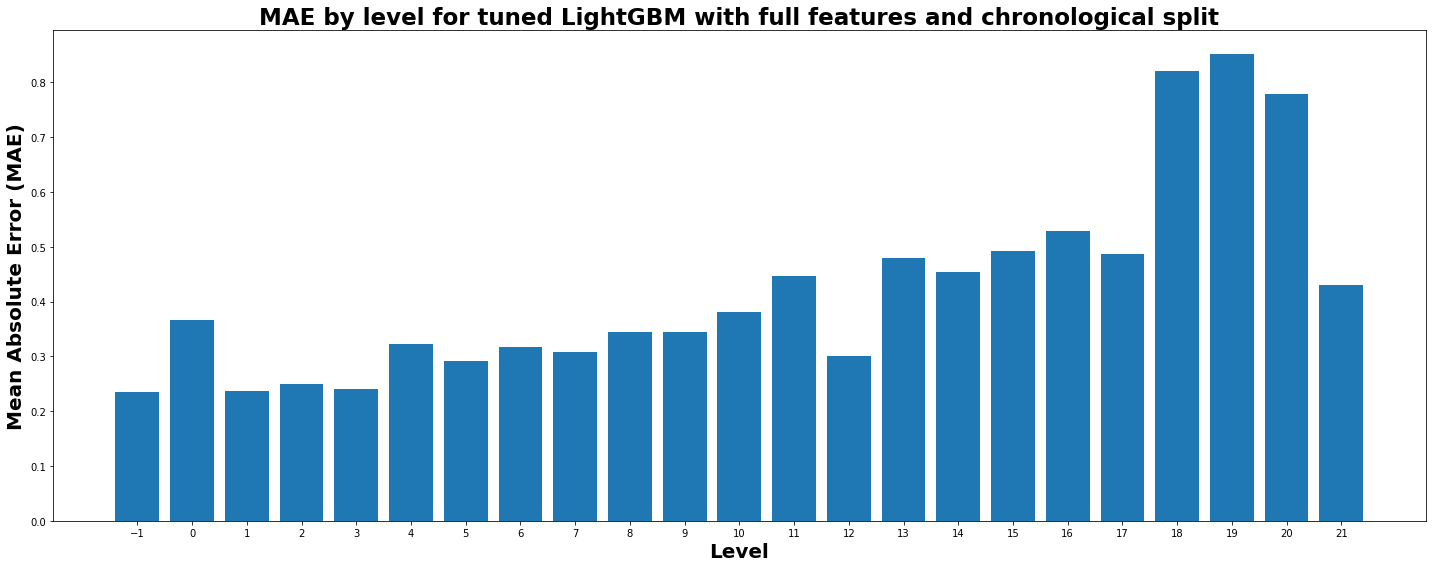

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and chronological split",
    export=True,
)

In [28]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.55

Round type: 0.5
RMSE: 0.59

Round type: 0.33
RMSE: 0.61

Round type: 0.45
RMSE: 0.59



In [29]:
predict[predict < -1] = -1
predict[predict > 21] = -1

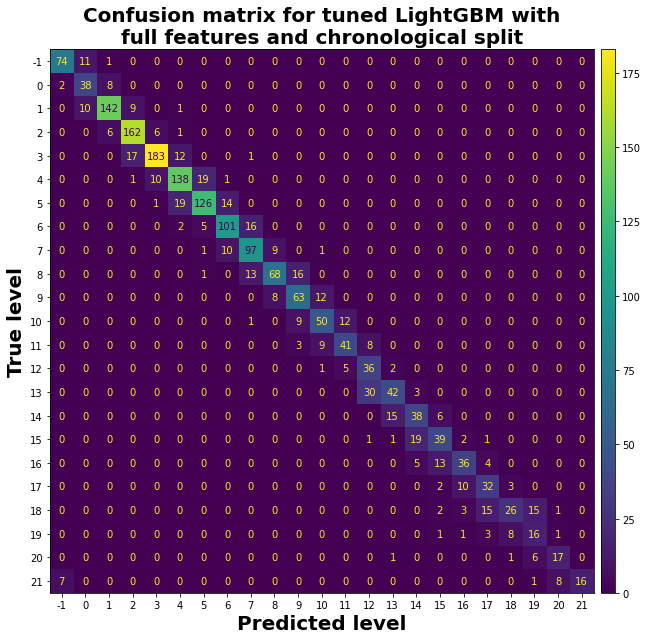

In [30]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nfull features and chronological split",
    export=True,
)

## Random split

In [31]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 2767, number of used features: 50
[LightGBM] [Info] Start training from score 7.220455
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.258236	valid_0's l2: 0.144298


In [32]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.38
MAE: 0.26


In [34]:
results.loc[2] = ["random", "default", "full", rmse, mae]

###### MAE by level

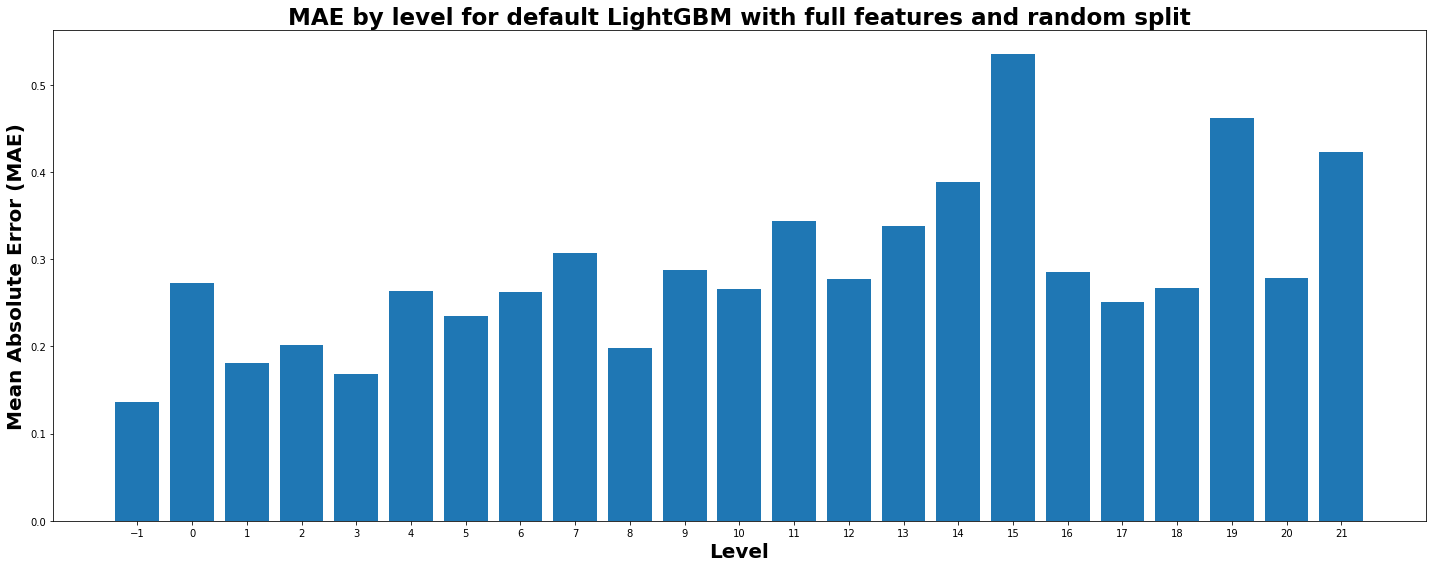

In [35]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and random split",
)

In [36]:
evaluate_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.38

Round type: 0.5
RMSE: 0.41

Round type: 0.33
RMSE: 0.45

Round type: 0.45
RMSE: 0.42



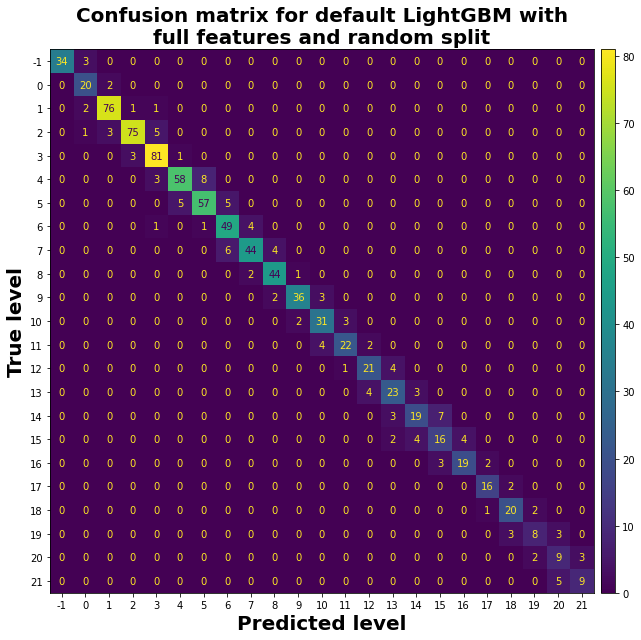

In [37]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with\nfull features and random split",
)

### Tuning

In [38]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-12-01 17:47:58,888] A new study created in memory with name: no-name-e55c03b9-7bf6-4fa7-8f5e-6a3a05699324
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.207445 + 0.052438
[200]	cv_agg's l2: 0.204823 + 0.0507437


feature_fraction, val_score: 0.204742:  14%|######4                                      | 1/7 [00:02<00:12,  2.12s/it]

[300]	cv_agg's l2: 0.206237 + 0.0502517
Early stopping, best iteration is:
[203]	cv_agg's l2: 0.204742 + 0.0507545
[100]	cv_agg's l2: 0.206724 + 0.0457084
[200]	cv_agg's l2: 0.204508 + 0.0456553


feature_fraction, val_score: 0.203915:  14%|######4                                      | 1/7 [00:04<00:12,  2.12s/it]

[300]	cv_agg's l2: 0.204506 + 0.0459229
Early stopping, best iteration is:
[228]	cv_agg's l2: 0.203915 + 0.0459196


feature_fraction, val_score: 0.203915:  29%|############8                                | 2/7 [00:04<00:11,  2.27s/it]

[100]	cv_agg's l2: 0.219894 + 0.0593204
[200]	cv_agg's l2: 0.21546 + 0.0562051


feature_fraction, val_score: 0.203915:  29%|############8                                | 2/7 [00:07<00:11,  2.27s/it]

[300]	cv_agg's l2: 0.216315 + 0.0552763
Early stopping, best iteration is:
[228]	cv_agg's l2: 0.203915 + 0.0459196


feature_fraction, val_score: 0.203915:  43%|###################2                         | 3/7 [00:07<00:09,  2.39s/it]

[100]	cv_agg's l2: 0.209979 + 0.0486148
[200]	cv_agg's l2: 0.207757 + 0.0471028


feature_fraction, val_score: 0.203915:  57%|#########################7                   | 4/7 [00:09<00:06,  2.32s/it]

[300]	cv_agg's l2: 0.208857 + 0.0471403
Early stopping, best iteration is:
[228]	cv_agg's l2: 0.203915 + 0.0459196
[100]	cv_agg's l2: 0.219279 + 0.0616989
[200]	cv_agg's l2: 0.216678 + 0.0600617


feature_fraction, val_score: 0.203915:  71%|################################1            | 5/7 [00:11<00:04,  2.28s/it]

[300]	cv_agg's l2: 0.217089 + 0.0594832
Early stopping, best iteration is:
[228]	cv_agg's l2: 0.203915 + 0.0459196
[100]	cv_agg's l2: 0.213508 + 0.0381157
[200]	cv_agg's l2: 0.212453 + 0.0381714


feature_fraction, val_score: 0.203915:  71%|################################1            | 5/7 [00:13<00:04,  2.28s/it]

[300]	cv_agg's l2: 0.212577 + 0.0388642
Early stopping, best iteration is:
[228]	cv_agg's l2: 0.203915 + 0.0459196


feature_fraction, val_score: 0.203915:  86%|######################################5      | 6/7 [00:13<00:02,  2.30s/it]

[100]	cv_agg's l2: 0.212565 + 0.0452236
[200]	cv_agg's l2: 0.211242 + 0.0450397


feature_fraction, val_score: 0.203915:  86%|######################################5      | 6/7 [00:16<00:02,  2.30s/it]

[300]	cv_agg's l2: 0.212052 + 0.0447315
Early stopping, best iteration is:
[228]	cv_agg's l2: 0.203915 + 0.0459196


num_leaves, val_score: 0.203915:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.208231 + 0.0455609
[200]	cv_agg's l2: 0.209013 + 0.0453051
[300]	cv_agg's l2: 0.209936 + 0.0452401


num_leaves, val_score: 0.203915:   5%|##5                                               | 1/20 [00:05<01:38,  5.20s/it]

Early stopping, best iteration is:
[228]	cv_agg's l2: 0.203915 + 0.0459196
[100]	cv_agg's l2: 0.208166 + 0.0403792
[200]	cv_agg's l2: 0.202772 + 0.0383998
[300]	cv_agg's l2: 0.202156 + 0.0376202


num_leaves, val_score: 0.201862:  10%|#####                                             | 2/20 [00:07<00:59,  3.31s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.207373 + 0.0419661
[200]	cv_agg's l2: 0.208023 + 0.0428111
[300]	cv_agg's l2: 0.209199 + 0.0427778


num_leaves, val_score: 0.201862:  15%|#######5                                          | 3/20 [00:11<01:04,  3.82s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.271417 + 0.0499876
[200]	cv_agg's l2: 0.248029 + 0.0440608


num_leaves, val_score: 0.201862:  20%|##########                                        | 4/20 [00:12<00:43,  2.73s/it]

[300]	cv_agg's l2: 0.236586 + 0.0418964
Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.208231 + 0.0455609
[200]	cv_agg's l2: 0.209013 + 0.0453051
[300]	cv_agg's l2: 0.209936 + 0.0452401


num_leaves, val_score: 0.201862:  25%|############5                                     | 5/20 [00:18<00:56,  3.76s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.241073 + 0.0473759
[200]	cv_agg's l2: 0.225811 + 0.0442824


num_leaves, val_score: 0.201862:  30%|###############                                   | 6/20 [00:19<00:40,  2.89s/it]

[300]	cv_agg's l2: 0.217847 + 0.0441877
Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.208022 + 0.0456631
[200]	cv_agg's l2: 0.208856 + 0.0453246
[300]	cv_agg's l2: 0.210076 + 0.0450407


num_leaves, val_score: 0.201862:  35%|#################5                                | 7/20 [00:24<00:47,  3.64s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.208231 + 0.0455609
[200]	cv_agg's l2: 0.209013 + 0.0453051
[300]	cv_agg's l2: 0.209936 + 0.0452401


num_leaves, val_score: 0.201862:  40%|####################                              | 8/20 [00:30<00:53,  4.43s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.208231 + 0.0455609
[200]	cv_agg's l2: 0.209013 + 0.0453051
[300]	cv_agg's l2: 0.209936 + 0.0452401


num_leaves, val_score: 0.201862:  45%|######################5                           | 9/20 [00:39<01:04,  5.85s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.204451 + 0.0426512
[200]	cv_agg's l2: 0.205706 + 0.0425777
[300]	cv_agg's l2: 0.207382 + 0.0430008


num_leaves, val_score: 0.201862:  50%|########################5                        | 10/20 [00:49<01:09,  6.98s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.208231 + 0.0455609
[200]	cv_agg's l2: 0.209013 + 0.0453051
[300]	cv_agg's l2: 0.209936 + 0.0452401


num_leaves, val_score: 0.201862:  55%|##########################9                      | 11/20 [01:00<01:13,  8.18s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.205518 + 0.044805
[200]	cv_agg's l2: 0.205137 + 0.0445535
[300]	cv_agg's l2: 0.206077 + 0.0445411


num_leaves, val_score: 0.201862:  60%|#############################4                   | 12/20 [01:06<01:00,  7.54s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.208231 + 0.0455609
[200]	cv_agg's l2: 0.209013 + 0.0453051
[300]	cv_agg's l2: 0.209936 + 0.0452401


num_leaves, val_score: 0.201862:  65%|###############################8                 | 13/20 [01:17<01:00,  8.57s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.207086 + 0.0471875
[200]	cv_agg's l2: 0.205704 + 0.0454991
[300]	cv_agg's l2: 0.207434 + 0.0455503


num_leaves, val_score: 0.201862:  70%|##################################3              | 14/20 [01:22<00:46,  7.69s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.208231 + 0.0455609
[200]	cv_agg's l2: 0.209013 + 0.0453051
[300]	cv_agg's l2: 0.209936 + 0.0452401


num_leaves, val_score: 0.201862:  75%|####################################7            | 15/20 [01:33<00:42,  8.56s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.208231 + 0.0455609
[200]	cv_agg's l2: 0.209013 + 0.0453051
[300]	cv_agg's l2: 0.209936 + 0.0452401


num_leaves, val_score: 0.201862:  80%|#######################################2         | 16/20 [01:44<00:36,  9.24s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.208231 + 0.0455609
[200]	cv_agg's l2: 0.209013 + 0.0453051
[300]	cv_agg's l2: 0.209936 + 0.0452401


num_leaves, val_score: 0.201862:  85%|#########################################6       | 17/20 [01:55<00:29,  9.72s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.208231 + 0.0455609
[200]	cv_agg's l2: 0.209013 + 0.0453051
[300]	cv_agg's l2: 0.209936 + 0.0452401


num_leaves, val_score: 0.201862:  90%|############################################1    | 18/20 [02:07<00:21, 10.53s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.205659 + 0.0430991
[200]	cv_agg's l2: 0.206707 + 0.0437868
[300]	cv_agg's l2: 0.208732 + 0.0444465


num_leaves, val_score: 0.201862:  95%|##############################################5  | 19/20 [02:14<00:09,  9.34s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.207068 + 0.0437094
[200]	cv_agg's l2: 0.207259 + 0.0440003
[300]	cv_agg's l2: 0.208356 + 0.0439732


num_leaves, val_score: 0.201862: 100%|#################################################| 20/20 [02:24<00:00,  7.21s/it]


Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168


bagging, val_score: 0.201862:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.226373 + 0.0430364
[200]	cv_agg's l2: 0.218149 + 0.0409522
[300]	cv_agg's l2: 0.216561 + 0.0373398


bagging, val_score: 0.201862:  10%|#####3                                               | 1/10 [00:03<00:34,  3.83s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.208166 + 0.0403792
[200]	cv_agg's l2: 0.202772 + 0.0383998
[300]	cv_agg's l2: 0.202156 + 0.0376202


bagging, val_score: 0.201862:  20%|##########6                                          | 2/10 [00:07<00:32,  4.02s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.217862 + 0.0439343
[200]	cv_agg's l2: 0.212234 + 0.0422806
[300]	cv_agg's l2: 0.211039 + 0.0408674


bagging, val_score: 0.201862:  30%|###############9                                     | 3/10 [00:12<00:28,  4.12s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.209707 + 0.0420055
[200]	cv_agg's l2: 0.203653 + 0.0397708
[300]	cv_agg's l2: 0.203275 + 0.0406948


bagging, val_score: 0.201862:  40%|#####################2                               | 4/10 [00:16<00:25,  4.24s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.212151 + 0.0432652
[200]	cv_agg's l2: 0.207081 + 0.041927
[300]	cv_agg's l2: 0.205929 + 0.0406404


bagging, val_score: 0.201862:  50%|##########################5                          | 5/10 [00:20<00:20,  4.12s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.214359 + 0.0446103
[200]	cv_agg's l2: 0.207717 + 0.0414808
[300]	cv_agg's l2: 0.207151 + 0.0398605


bagging, val_score: 0.201862:  60%|###############################8                     | 6/10 [00:24<00:16,  4.07s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.215135 + 0.0469076
[200]	cv_agg's l2: 0.21048 + 0.0430586
[300]	cv_agg's l2: 0.211015 + 0.0426544


bagging, val_score: 0.201862:  70%|#####################################                | 7/10 [00:28<00:12,  4.07s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.211116 + 0.0467135
[200]	cv_agg's l2: 0.206223 + 0.0450878
[300]	cv_agg's l2: 0.205863 + 0.0447844


bagging, val_score: 0.201862:  80%|##########################################4          | 8/10 [00:32<00:08,  4.06s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.213804 + 0.045467
[200]	cv_agg's l2: 0.207026 + 0.0402587
[300]	cv_agg's l2: 0.206682 + 0.0398781


bagging, val_score: 0.201862:  90%|###############################################7     | 9/10 [00:36<00:04,  4.01s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.219968 + 0.0444454
[200]	cv_agg's l2: 0.21418 + 0.041655
[300]	cv_agg's l2: 0.213061 + 0.0408012


bagging, val_score: 0.201862: 100%|####################################################| 10/10 [00:40<00:00,  4.06s/it]


Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168


feature_fraction_stage2, val_score: 0.201862:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.212068 + 0.0408794
[200]	cv_agg's l2: 0.207502 + 0.0387784
[300]	cv_agg's l2: 0.208035 + 0.0388855


feature_fraction_stage2, val_score: 0.201862:  17%|######3                               | 1/6 [00:03<00:19,  3.96s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.212984 + 0.0419637
[200]	cv_agg's l2: 0.208047 + 0.0398103
[300]	cv_agg's l2: 0.207129 + 0.0389252


feature_fraction_stage2, val_score: 0.201862:  33%|############6                         | 2/6 [00:07<00:15,  3.90s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.210958 + 0.0429264
[200]	cv_agg's l2: 0.20594 + 0.0422066
[300]	cv_agg's l2: 0.205182 + 0.0429219


feature_fraction_stage2, val_score: 0.201862:  50%|###################                   | 3/6 [00:11<00:11,  3.95s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.212667 + 0.0425681
[200]	cv_agg's l2: 0.208508 + 0.0416746
[300]	cv_agg's l2: 0.207724 + 0.041994


feature_fraction_stage2, val_score: 0.201862:  67%|#########################3            | 4/6 [00:16<00:08,  4.05s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.21255 + 0.0451252
[200]	cv_agg's l2: 0.207761 + 0.0429606
[300]	cv_agg's l2: 0.207759 + 0.0420204


feature_fraction_stage2, val_score: 0.201862:  83%|###############################6      | 5/6 [00:19<00:03,  3.94s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.216696 + 0.0349982
[200]	cv_agg's l2: 0.211467 + 0.0331942
[300]	cv_agg's l2: 0.210039 + 0.0337121


feature_fraction_stage2, val_score: 0.201862: 100%|######################################| 6/6 [00:23<00:00,  3.95s/it]


Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168


regularization_factors, val_score: 0.201862:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.22553 + 0.046039
[200]	cv_agg's l2: 0.216447 + 0.0447081


regularization_factors, val_score: 0.201862:   5%|#9                                    | 1/20 [00:02<00:51,  2.71s/it]

[300]	cv_agg's l2: 0.215872 + 0.0448004
Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.224978 + 0.0521311
[200]	cv_agg's l2: 0.215332 + 0.0493155
[300]	cv_agg's l2: 0.213682 + 0.0481521


regularization_factors, val_score: 0.201862:  10%|###8                                  | 2/20 [00:06<01:02,  3.45s/it]

Early stopping, best iteration is:
[252]	cv_agg's l2: 0.201862 + 0.0377168
[100]	cv_agg's l2: 0.208167 + 0.0403794
[200]	cv_agg's l2: 0.202617 + 0.0381169
[300]	cv_agg's l2: 0.20204 + 0.0379832


regularization_factors, val_score: 0.201589:  15%|#####7                                | 3/20 [00:11<01:06,  3.91s/it]

Early stopping, best iteration is:
[282]	cv_agg's l2: 0.201589 + 0.0378864
[100]	cv_agg's l2: 0.208167 + 0.0403793
[200]	cv_agg's l2: 0.202623 + 0.0381075
[300]	cv_agg's l2: 0.202443 + 0.0372791


regularization_factors, val_score: 0.201589:  20%|#######6                              | 4/20 [00:15<01:06,  4.15s/it]

Early stopping, best iteration is:
[282]	cv_agg's l2: 0.201589 + 0.0378864
[100]	cv_agg's l2: 0.208167 + 0.0403794
[200]	cv_agg's l2: 0.202617 + 0.0381169
[300]	cv_agg's l2: 0.201768 + 0.0380898
[400]	cv_agg's l2: 0.201327 + 0.0380509


regularization_factors, val_score: 0.201149:  25%|#########5                            | 5/20 [00:21<01:11,  4.78s/it]

[500]	cv_agg's l2: 0.201793 + 0.0376485
Early stopping, best iteration is:
[413]	cv_agg's l2: 0.201149 + 0.0378171
[100]	cv_agg's l2: 0.208167 + 0.0403795
[200]	cv_agg's l2: 0.202617 + 0.038117
[300]	cv_agg's l2: 0.201768 + 0.0380898
[400]	cv_agg's l2: 0.201327 + 0.0380509


regularization_factors, val_score: 0.201149:  30%|###########4                          | 6/20 [00:27<01:12,  5.16s/it]

[500]	cv_agg's l2: 0.201793 + 0.0376485
Early stopping, best iteration is:
[413]	cv_agg's l2: 0.201149 + 0.0378171
[100]	cv_agg's l2: 0.208167 + 0.0403794
[200]	cv_agg's l2: 0.202617 + 0.0381169
[300]	cv_agg's l2: 0.20204 + 0.0379832
[400]	cv_agg's l2: 0.20203 + 0.0378119


regularization_factors, val_score: 0.201149:  35%|#############3                        | 7/20 [00:32<01:08,  5.27s/it]

[500]	cv_agg's l2: 0.202293 + 0.0373412
Early stopping, best iteration is:
[413]	cv_agg's l2: 0.201149 + 0.0378171
[100]	cv_agg's l2: 0.208167 + 0.0403793
[200]	cv_agg's l2: 0.202623 + 0.0381075
[300]	cv_agg's l2: 0.202443 + 0.037279
[400]	cv_agg's l2: 0.202954 + 0.0378318


regularization_factors, val_score: 0.201149:  40%|###############2                      | 8/20 [00:38<01:03,  5.28s/it]

[500]	cv_agg's l2: 0.203963 + 0.0380097
Early stopping, best iteration is:
[413]	cv_agg's l2: 0.201149 + 0.0378171
[100]	cv_agg's l2: 0.208167 + 0.0403795
[200]	cv_agg's l2: 0.202617 + 0.038117
[300]	cv_agg's l2: 0.201768 + 0.0380898
[400]	cv_agg's l2: 0.201327 + 0.0380509


regularization_factors, val_score: 0.201149:  45%|#################1                    | 9/20 [00:43<00:59,  5.41s/it]

[500]	cv_agg's l2: 0.201792 + 0.0376485
Early stopping, best iteration is:
[413]	cv_agg's l2: 0.201149 + 0.0378172
[100]	cv_agg's l2: 0.208167 + 0.0403795
[200]	cv_agg's l2: 0.202617 + 0.038117
[300]	cv_agg's l2: 0.201774 + 0.0378956
[400]	cv_agg's l2: 0.201728 + 0.0385119


regularization_factors, val_score: 0.201077:  50%|##################5                  | 10/20 [00:49<00:54,  5.50s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.208168 + 0.0403796
[200]	cv_agg's l2: 0.202773 + 0.0381412
[300]	cv_agg's l2: 0.202733 + 0.038411
[400]	cv_agg's l2: 0.203051 + 0.038682


regularization_factors, val_score: 0.201077:  55%|####################3                | 11/20 [00:55<00:50,  5.59s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.208167 + 0.0403794
[200]	cv_agg's l2: 0.202617 + 0.0381169
[300]	cv_agg's l2: 0.20204 + 0.0379832
[400]	cv_agg's l2: 0.20203 + 0.0378119


regularization_factors, val_score: 0.201077:  60%|######################2              | 12/20 [01:00<00:43,  5.48s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.208167 + 0.0403795
[200]	cv_agg's l2: 0.202617 + 0.038117
[300]	cv_agg's l2: 0.201768 + 0.0380898
[400]	cv_agg's l2: 0.201327 + 0.0380509


regularization_factors, val_score: 0.201077:  65%|########################             | 13/20 [01:07<00:42,  6.02s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.208598 + 0.0401588
[200]	cv_agg's l2: 0.202951 + 0.0380641
[300]	cv_agg's l2: 0.20358 + 0.0383863
[400]	cv_agg's l2: 0.203568 + 0.0388049


regularization_factors, val_score: 0.201077:  70%|#########################9           | 14/20 [01:14<00:36,  6.14s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.208167 + 0.0403795
[200]	cv_agg's l2: 0.202617 + 0.038117
[300]	cv_agg's l2: 0.201774 + 0.0378956
[400]	cv_agg's l2: 0.201728 + 0.0385119


regularization_factors, val_score: 0.201077:  75%|###########################7         | 15/20 [01:19<00:29,  5.91s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.210727 + 0.0406328
[200]	cv_agg's l2: 0.206028 + 0.0391398
[300]	cv_agg's l2: 0.204551 + 0.0390418
[400]	cv_agg's l2: 0.204419 + 0.0387982


regularization_factors, val_score: 0.201077:  80%|#############################6       | 16/20 [01:25<00:23,  5.81s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.20997 + 0.0414911
[200]	cv_agg's l2: 0.20547 + 0.04171
[300]	cv_agg's l2: 0.204372 + 0.041355
[400]	cv_agg's l2: 0.203785 + 0.0415882


regularization_factors, val_score: 0.201077:  85%|###############################4     | 17/20 [01:30<00:16,  5.52s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.208167 + 0.0403792
[200]	cv_agg's l2: 0.203533 + 0.0380915
[300]	cv_agg's l2: 0.202927 + 0.0372141
[400]	cv_agg's l2: 0.203535 + 0.0377145


regularization_factors, val_score: 0.201077:  90%|#################################3   | 18/20 [01:35<00:10,  5.49s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.210848 + 0.0407453
[200]	cv_agg's l2: 0.20527 + 0.038328
[300]	cv_agg's l2: 0.20332 + 0.0375972
[400]	cv_agg's l2: 0.203274 + 0.0372886


regularization_factors, val_score: 0.201077:  95%|###################################1 | 19/20 [01:40<00:05,  5.34s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.208167 + 0.0403792
[200]	cv_agg's l2: 0.203278 + 0.0378485
[300]	cv_agg's l2: 0.202914 + 0.0371158
[400]	cv_agg's l2: 0.203431 + 0.0379214


regularization_factors, val_score: 0.201077: 100%|#####################################| 20/20 [01:45<00:00,  5.27s/it]


Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885


min_data_in_leaf, val_score: 0.201077:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.208311 + 0.0435424
[200]	cv_agg's l2: 0.203611 + 0.0439657
[300]	cv_agg's l2: 0.202436 + 0.0427755
[400]	cv_agg's l2: 0.202259 + 0.0424973


min_data_in_leaf, val_score: 0.201077:  20%|#########                                    | 1/5 [00:04<00:19,  4.92s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.213906 + 0.0429891
[200]	cv_agg's l2: 0.208216 + 0.0413484
[300]	cv_agg's l2: 0.207568 + 0.0405278
[400]	cv_agg's l2: 0.208186 + 0.0408695


min_data_in_leaf, val_score: 0.201077:  40%|##################                           | 2/5 [00:10<00:15,  5.08s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.223016 + 0.0426248
[200]	cv_agg's l2: 0.214147 + 0.0392129
[300]	cv_agg's l2: 0.212301 + 0.0370328
[400]	cv_agg's l2: 0.211766 + 0.0362942


min_data_in_leaf, val_score: 0.201077:  60%|###########################                  | 3/5 [00:14<00:09,  4.95s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.2618 + 0.0453859
[200]	cv_agg's l2: 0.244592 + 0.0442247
[300]	cv_agg's l2: 0.237395 + 0.043465
[400]	cv_agg's l2: 0.233363 + 0.042339


min_data_in_leaf, val_score: 0.201077:  80%|####################################         | 4/5 [00:18<00:04,  4.46s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.201077 + 0.0378885
[100]	cv_agg's l2: 0.205974 + 0.0442674
[200]	cv_agg's l2: 0.199297 + 0.0421398
[300]	cv_agg's l2: 0.197684 + 0.0413629
[400]	cv_agg's l2: 0.197456 + 0.0413216


min_data_in_leaf, val_score: 0.197372: 100%|#############################################| 5/5 [00:24<00:00,  4.83s/it]

[500]	cv_agg's l2: 0.19766 + 0.0411044
Early stopping, best iteration is:
[407]	cv_agg's l2: 0.197372 + 0.0412579


In [39]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1973721023700303
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0004714984719906017
    lambda_l2: 1.1589984806906116e-08
    num_leaves: 23
    feature_fraction: 0.5
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


In [40]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [41]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.02
RMSE test: 0.35
MAE test: 0.24



In [42]:
results.loc[3] = ["random", "Optuna", "full", rmse, mae]

###### MAE by level

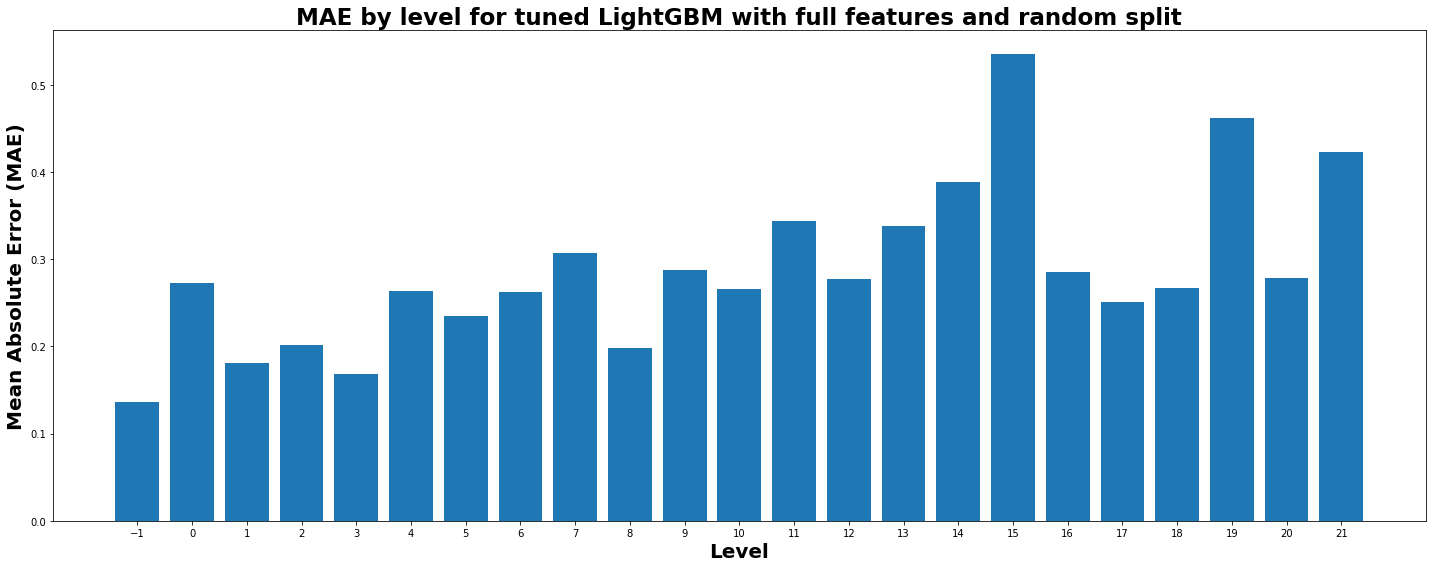

In [43]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and random split",
    export=True,
)

In [44]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.19

Round type: 0.5
RMSE: 0.20

Round type: 0.33
RMSE: 0.22

Round type: 0.45
RMSE: 0.20



In [45]:
predict[predict < -1] = -1
predict[predict > 21] = 21

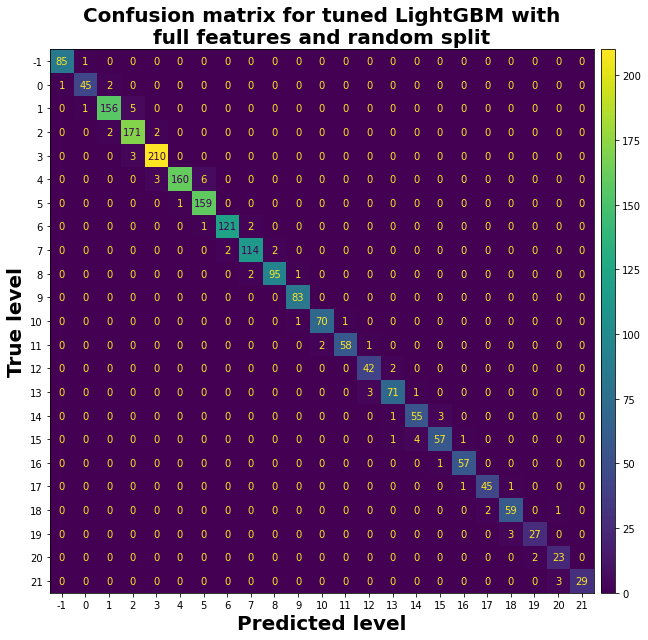

In [46]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nfull features and random split",
    export=True,
)

### Best features

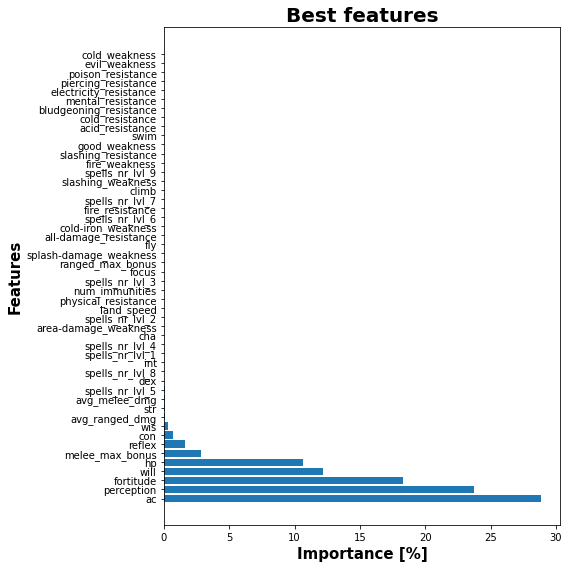

In [47]:
lgb_importances = lgb_tuned.feature_importance(importance_type="gain")
lgb_importances = (lgb_importances / lgb_importances.sum()) * 100
feature_names = lgb_tuned.feature_name()


data = list(zip(lgb_importances, feature_names))
sorted_data = sorted(data, key=lambda x: x[0], reverse=True)
lgb_importances, feature_names = zip(*sorted_data)

plt.figure(figsize=(8, 8))
plt.barh(feature_names, lgb_importances)
plt.xlabel("Importance [%]", fontweight="bold", fontsize=15)
plt.ylabel("Features", fontweight="bold", fontsize=15)
plt.title("Best features", fontweight="bold", fontsize=20)
plt.tight_layout()

plt.show()

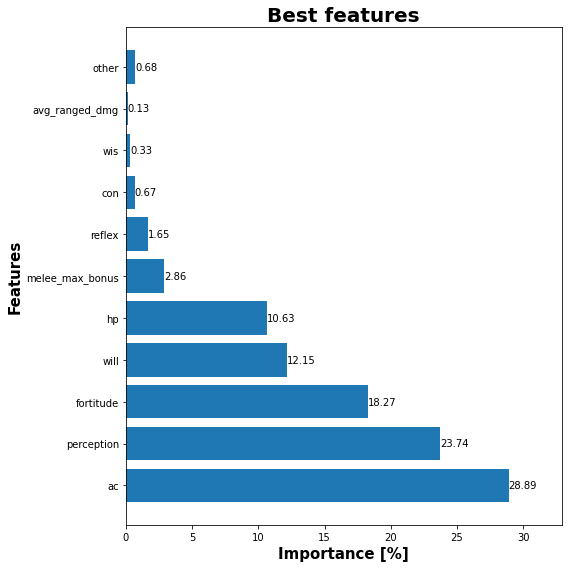

In [48]:
top_features = sorted_data[:10]
lgb_importances, feature_names = zip(*top_features)

lgb_importances = list(lgb_importances)
feature_names = list(feature_names)

lgb_importances.append(100 - sum(lgb_importances))
feature_names.append("other")


plt.figure(figsize=(8, 8))
bars = plt.barh(feature_names, lgb_importances, label=lgb_importances)
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        round(bar.get_width(), 2),
        ha="left",
        va="center",
    )


plt.xlabel("Importance [%]", fontweight="bold", fontsize=15)
plt.ylabel("Features", fontweight="bold", fontsize=15)
plt.title("Best features", fontweight="bold", fontsize=20)

plt.xlim(0, max(lgb_importances) + 4)

plt.tight_layout()
plt.savefig(f"../results_diagrams/other/Best features.svg")
plt.show()

## Summary

In [49]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,full,0.596520,0.356037
1,chronological,Optuna,full,0.554453,0.349337
2,random,default,full,0.379865,0.258236
3,random,Optuna,full,0.348791,0.236097


In [50]:
from training.results import plot_summary

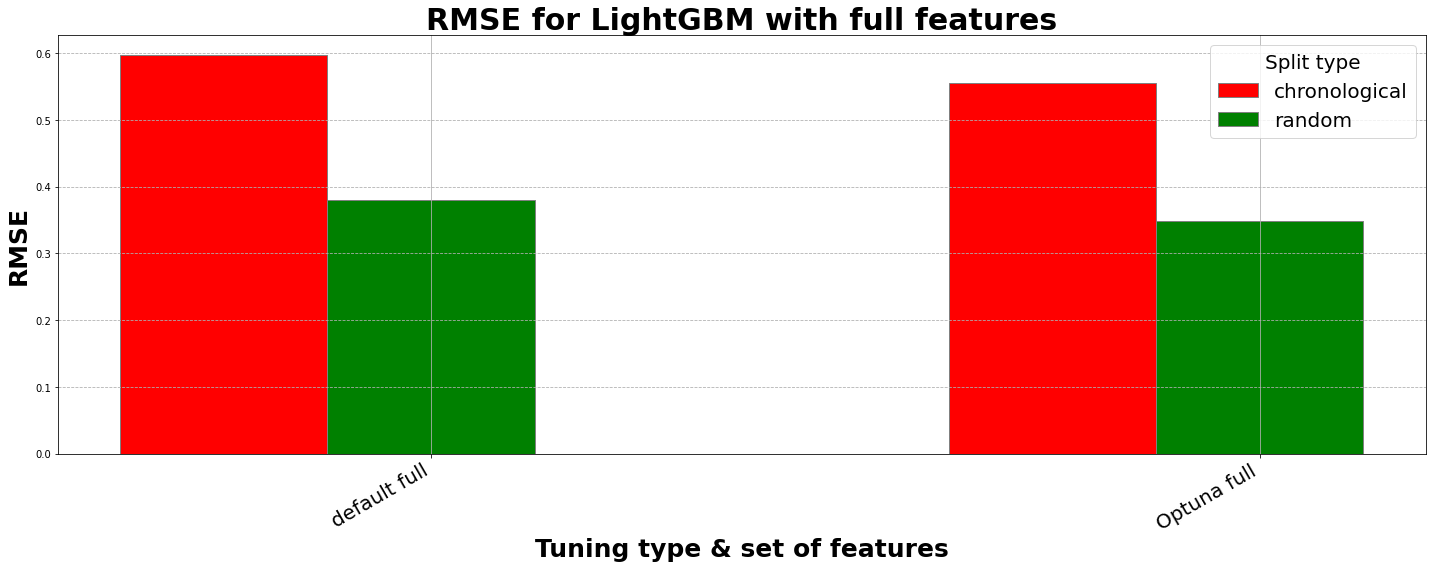

In [51]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with full features")

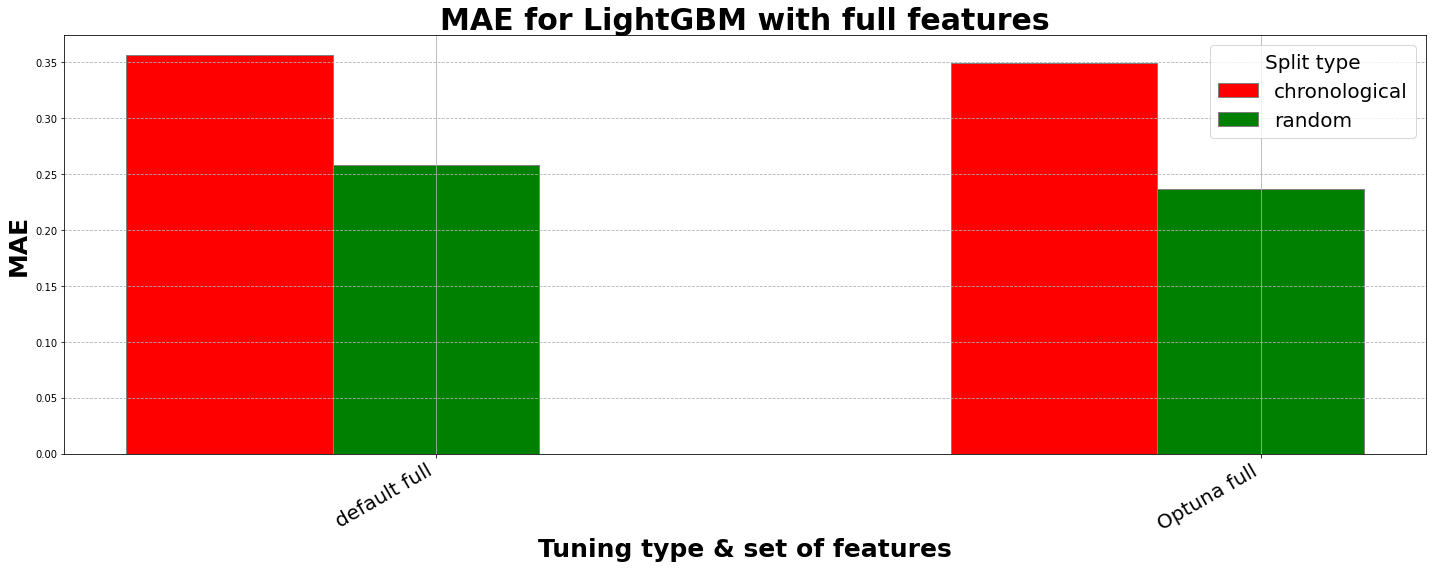

In [52]:
plot_summary(results, "MAE", title="MAE for LightGBM with full features")

In [53]:
results.to_csv("./lightgbm_full_results.csv")